# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Нужные библиотеки:**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

**глобальные константы:**

In [2]:
state = np.random.RandomState(12345)

**загрузка данных:**

In [3]:
try:
    df_0 = pd.read_csv('geo_data_0.csv')
except:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
try:
    df_1 = pd.read_csv('geo_data_1.csv')
except:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [5]:
try:
    df_2 = pd.read_csv('geo_data_2.csv')
except:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

понимаю, что выглядит это довольно страшно, но я руководстовался тем, что я подгружаю каждый датасет независимо от другого, поэтому если мне надо будет заново подгрузить один из датасетов мне не придетс трогать оставшеся

In [6]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
def check_dataset(df, num):
    print(f'Количество дупликатов в {num + 1}-ом датасете: {df.duplicated().sum()}')
    print('Корреляционная матрица:', df.corr(), sep='\n')
    print(f'Количество NaN-значений во всех строках в {num + 1}-ем датасете: {df.isna().sum().sum()}')
    print()
    return

In [10]:
dfs = [df_0, df_1, df_2]
for num in range(len(dfs)):
    check_dataset(dfs[num], num)

Количество дупликатов в 1-ом датасете: 0
Корреляционная матрица:
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
Количество NaN-значений во всех строках в 1-ем датасете: 0

Количество дупликатов в 2-ом датасете: 0
Корреляционная матрица:
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
Количество NaN-значений во всех строках в 2-ем датасете: 0

Количество дупликатов в 3-ом датасете: 0
Корреляционная матрица:
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.00

### Вывод:
Загрузил данные, все норм! Нет дубликатов, нет NaN-значений, нет мультиколлинеарности.

## Обучение и проверка модели

In [11]:
def fit_func(df, i):
    target = df['product']
    features = df.drop(['product', 'id'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
                                                features, target, test_size=0.25, random_state=state)
    numeric = ['f0', 'f1', 'f2']

    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    
    print(f'RMSE для {i} региона: {rmse.round(4)}')
    print(f'Средний запас предсказанного сырья для {i}: {predicted_valid.mean().round(4)}')
    print(f'R2: {r2_score(target_valid, predicted_valid)}')
    return predicted_valid, target_valid

In [12]:
predict_valid_0, target_valid_0 = fit_func(df_0, 1)

RMSE для 1 региона: 37.5794
Средний запас предсказанного сырья для 1: 92.5926
R2: 0.27994321524487786


In [13]:
predict_valid_1, target_valid_1 = fit_func(df_1, 2)

RMSE для 2 региона: 0.8897
Средний запас предсказанного сырья для 2: 68.77
R2: 0.9996264922748638


In [14]:
predict_valid_2, target_valid_2 = fit_func(df_2, 3)

RMSE для 3 региона: 39.958
Средний запас предсказанного сырья для 3: 95.0875
R2: 0.20261508041163934


In [15]:
target_valid_0.reset_index(drop=True, inplace=True)
target_valid_1.reset_index(drop=True, inplace=True)
target_valid_2.reset_index(drop=True, inplace=True)

#### Вывод:
Для задачи предсказывания объема добачи выбрал линейную регрессию, по итогу модель работает почти идеально только для одного региона, а для остальных регионов работает примерно как среднее, это подтверждает каэффициент детерминации для каждого из регионов. 

## Подготовка к расчёту прибыли

In [16]:
# топ лучших точек
MAX_COUNT = 200
# бюджет
BUDGET = 10 ** 10
# доход с 1 баррели нефти
COST = 45 * (10**4)

Теперь посчитаем, какой должен быть минимальный объем сырья, чтобы новая разработка скважины была безубыточной:

In [17]:
min_volume = BUDGET / (COST * MAX_COUNT)
print(f'Минимальный объем добычи сырья для безубыточной добычи: {round(min_volume, 3)}')

Минимальный объем добычи сырья для безубыточной добычи: 111.111


In [18]:
vals = [df_0, df_1, df_2]
print('Среднее по регионам:')
for i in range(len(vals)):
    print(f'{i + 1} регион:', round(vals[i]['product'].mean(), 3))

Среднее по регионам:
1 регион: 92.5
2 регион: 68.825
3 регион: 95.0


#### Вывод:
Чтобы покрыть затраты на разработку новой местности все новые скважины должны добывать минимум 112 баррелей нефти, что больше чем средний запас во всех регионах. 

## Расчёт прибыли и рисков 

In [19]:
def revenue(pred, target, cnt):
    pred = pd.Series(pred).reset_index(drop=True).sort_values(ascending=False)
    target = target.reset_index(drop=True)
    selected = target[pred.index][:cnt]

    if target[pred.index].shape != pred.shape:
        print("Shape mismatch! Selected targets shape:", target[pred.index].shape)


    return COST * selected.sum() - BUDGET

In [20]:
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

Теперь рассчитаем прибыльность топ-200 самых производительных скважин по предсказаниям нашей модели:

In [22]:
preds = [predict_valid_0, predict_valid_1, predict_valid_2]
targets = [target_valid_0, target_valid_1, target_valid_2]
for i in range(len(preds)):
    revenue_pred = revenue(preds[i], targets[i], MAX_COUNT)
    print(f'Расчет прибыли для {i + 1}-го региона: {revenue_pred}')
    print(f'Доля от бюджета: {round(revenue_pred / BUDGET, 2)}')
    print()

Расчет прибыли для 1-го региона: 3320826043.1398506
Доля от бюджета: 0.33

Расчет прибыли для 2-го региона: 2415086696.681511
Доля от бюджета: 0.24

Расчет прибыли для 3-го региона: 2539915945.842947
Доля от бюджета: 0.25



#### Вывод:
по предсказаниям модели, в любом регионе 200 лучших скважин показывают хорошую прибыльность.

**Bootstrap**

In [23]:
values_dict = {0: [], 1: [], 2: []}
for j in range(len(preds)):
    for i in range(10 ** 3):
        pred_subsample = pd.Series(preds[j]).sample(n=500, replace=True, random_state=state)
        target_subsample = targets[j][pred_subsample.index]
        values_dict[j].append(revenue(pred_subsample, target_subsample, MAX_COUNT))
        
    values = pd.Series(values_dict[j])
    lower = round(values.quantile(0.025), 3)
    upper = round(values.quantile(0.975), 3)
    mean = round(values.mean(), 3)
    risk = (values < 0).mean() * 100
    
    print(f"Средняя выручка для {j + 1}-го региона:", mean)
    print("95% интервал:", lower, '|',upper)
    print('Риски:', round(risk, 2), '%')
    print()

Средняя выручка для 1-го региона: 394284411.341
95% интервал: -69450566.857 | 915496165.831
Риски: 6.1 %

Средняя выручка для 2-го региона: 454736359.097
95% интервал: 61071811.298 | 855914149.143
Риски: 0.7 %

Средняя выручка для 3-го региона: 353664097.525
95% интервал: -162650946.942 | 847761844.515
Риски: 7.6 %



(array([  5.,  16.,  70., 154., 217., 260., 156.,  84.,  34.,   4.]),
 array([-4.51127941e+08, -2.86128168e+08, -1.21128394e+08,  4.38713801e+07,
         2.08871154e+08,  3.73870928e+08,  5.38870702e+08,  7.03870476e+08,
         8.68870249e+08,  1.03387002e+09,  1.19886980e+09]),
 <BarContainer object of 10 artists>)

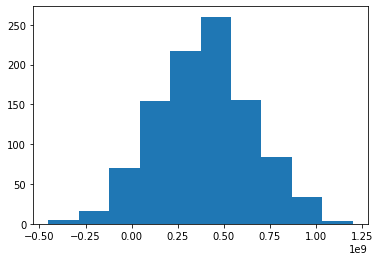

In [24]:
plt.hist(values_dict[0])

(array([  3.,   7.,  70., 129., 228., 248., 176.,  97.,  35.,   7.]),
 array([-2.42960973e+08, -1.10108350e+08,  2.27442741e+07,  1.55596898e+08,
         2.88449521e+08,  4.21302145e+08,  5.54154769e+08,  6.87007392e+08,
         8.19860016e+08,  9.52712639e+08,  1.08556526e+09]),
 <BarContainer object of 10 artists>)

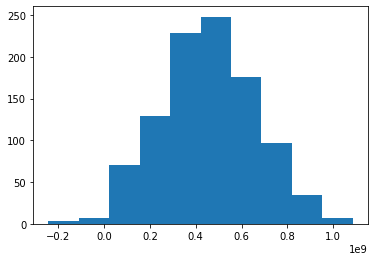

In [25]:
plt.hist(values_dict[1])

(array([  1.,   1.,  30.,  89., 233., 312., 216.,  92.,  21.,   5.]),
 array([-7.13048562e+08, -5.17971624e+08, -3.22894686e+08, -1.27817748e+08,
         6.72591898e+07,  2.62336128e+08,  4.57413066e+08,  6.52490004e+08,
         8.47566942e+08,  1.04264388e+09,  1.23772082e+09]),
 <BarContainer object of 10 artists>)

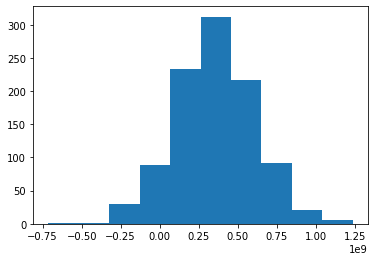

In [26]:
plt.hist(values_dict[2])

#### Вывод:
Явным лидером является второй регион, ведь в нем выше средняя выручка и ниже риск получить отрицательную прибыль.

## Общий вывод:
В проделанной работе можно выделить неколько этапов, по которым можно сделать вывод:
- 1) Загрузка данных.
- 2) Обучение модели линейной регресии, в процессе которого были выяснены метрики качества полученной модели, такие как R2 и RMSE.
- 3) Подготовка к подсчету прибыли, в ходе которой был посчитан безубыточный объем добычи.
- 4) Расчет прибыли и рисков методом Bootstrap. В ходе этого эпата было выяснено, что второй регион оказался лучшим для разработки новых скважин.